# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers

First we create the environment:

In [13]:
env = gym.make('CartPole-v0') # Create environment

A state in this environment is four numbers describing the position of the cart along with the angle and speed of the pole.
There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [14]:
s = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [ 0.00837907 -0.03052662 -0.02451294 -0.02696003]
sample action: 0


**Note:** you will likely not be able to render environments in a Google Colab instance. Therefore, it may be beneficial for you to run this week's notebooks locally and/or team up with another student if you do not have a local environment.

The function below is used for display:

In [15]:
def show_replay():
    """
    Not-so-elegant way to display the MP4 file generated by the Monitor wrapper inside a notebook.
    The Monitor wrapper dumps the replay to a local file that we then display as a HTML video object.
    """
    import io
    import base64
    from IPython.display import HTML
    video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [17]:
env = gym.make('CartPole-v0') # Create environment
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
env.reset() # Reset environment

# Run environment
while True:
    env.render() # Render environment
    action = env.action_space.sample() # Get a random action
    _, _, done, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
show_replay()

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [79]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [80]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [81]:
n_inputs = env.observation_space.shape[0]
n_hidden = 20
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [82]:
# training settings

num_episodes = 800
rollout_limit = 500 # max rollout length (time steps in each episode)
discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.01 #0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1) # gather is a type of reshape
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
 100. mean training reward:  17.43, mean validation reward:   9.70, mean loss:  6.1205
 200. mean training reward:  33.03, mean validation reward: 114.90, mean loss: 11.1254
 300. mean training reward:  53.77, mean validation reward: 171.80, mean loss: 15.9008
 400. mean training reward: 164.22, mean validation reward: 200.00, mean loss: 42.6256
 500. mean training reward: 140.63, mean validation reward: 200.00, mean loss: 36.3065
 600. mean training reward: 153.02, mean validation reward: 200.00, mean loss: 37.1540
 700. mean training reward: 187.22, mean validation reward: 200.00, mean loss: 44.0767
 800. mean training reward: 176.12, mean validation reward: 200.00, mean loss: 32.7887
done


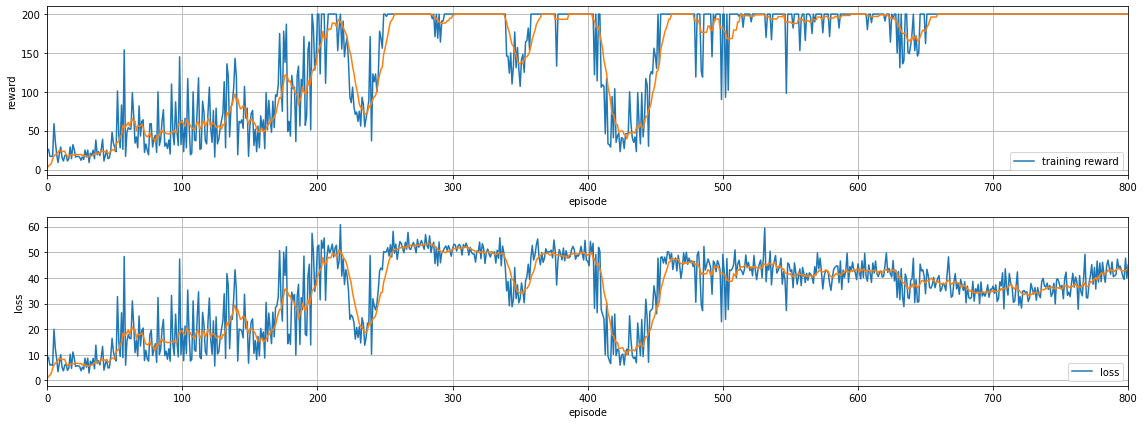

In [78]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [83]:
env = wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

t_steps = 500 # adjust to make video run longer (unless it breaks because it's done)
for _ in range(t_steps): 
    env.render()
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
env.close()
show_replay()

## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

- Initially: num_episodes = 800, rollout_limit = 500, discount_factor = 1.0, learning_rate = 0.001, val_freq = 100. At last episode (end of training), we get mean training reward: 165.55, mean validation reward: 200.00, mean loss: 50.0750.

- 1st try: Setting num_episodes = 2000. At last episode (end of training) mean training reward: 179.04, mean validation reward: 200.00, mean loss: 50.0600. Increasing the number of episodes did not increase the mean validation reward nor decrease the loss significantly. Also, the performance varies a lot (high variance in reward), due to the randomness.

- 2nd try: We go back to using num_episodes = 800. Now we set discount_factor = 0.5. At last episode (end of training), we get mean training reward:  14.74, mean validation reward:   8.80, mean loss:  1.0723. Decreasing the discount factor had a very negative effect on learning, since the mean validation reward went from 200 to 8.8. Setting discount_factor = 0.99 did not improve performance either.

- 3nd try: We go back to using discount_factor = 1. Now we set learning_rate = 0.01. The reward seems to max out on 200. 

- 4nd try: We continue with learning_rate = 0.01. We now add an extra hidden network layer..

- 5nd try: We continue with two hidden layers and now also increase rollout limit  

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

*Answer here...*

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

*Answer here...*

Note that the loss is computed as -torch.mean(torch.mul(torch.log(action_probabilities), returns)), so we multiply the action probabilities with the rewards (returns). 

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

*Answer here...*
When training the exploration part is when we use the multinomial function to choose an action (note that we choose a random action no matter the probability and not just the action with the highest probability)


### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*